In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as BS
import json
from io import StringIO
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

See https://github.com/CIAT-DAPA/climate_wizard_api section 2.1 and Table 4 for explanation of all arguments and their default, Table 2 for index, and Table 3 for gcm.

In [ ]:
class ClimateWizardCcafs:
  def __init__(self):
    # Required arguments
    self.lat = None
    self.lon = None
    self.index = None
    self.scenario = None

    # Optional arguments
    self.gcm = 'ensemble'
    self.start_yr = None
    self.end_yr = None
    self.avg = 'false'
    self.climatology = 'true'
    self.baseline = 'false'    
    self.geojson = None
    self.stats = None

  def set_lat_lon(self, lat=None, lon=None):
    self.lat, self.lon = lat, lon

  def set_Senegal_region(self, region):
    regions = {
        "saint louis":(16.03, -16.50),
        "louga": (15.65, -16.35),
        "matam": (15.62, -13.33),
        "dakar": (14.68, -17.43),
        "thies": (14.78, -16.92),
        "diourbel": (14.65, -16.23),
        "fatick": (14.33, -16.40),
        "kaolack": (14.02, -16.25),
        "kaffrine": (14.12, -15.70),
        "tambacounda": (13.77, -13.67),
        "ziguinchor": (12.55, -16.28),
        "seghiou": (12.70, -15.55),
        "kolda": (12.88, -14.95),
        "kedougou": (12.55, -12.18)
    }
    self.lat, self.lon = regions.get(region.lower()) \
                         if regions.get(region.lower()) \
                         else print("Invalid region")

  def set_scenario(self, is_historical=None, is_rcp45=None):
    self.scenario = 'historical' if is_historical else \
                    'rcp45' if is_rcp45 else 'rcp85'
    # TODO: simplify to just 2 options: historical or future

  def set_optional_args(self, **kwargs):
    for arg, value in kwargs.items():
      setattr(self, arg, value)

  def query_weather_forecast(self, **kwargs):
    self.set_optional_args(**kwargs)
    url = self._build_url()
    print(url)
    json_content = self._parse_html(url)
    data = self._parse_json(json_content)
    return data

  def _build_url(self):
    url = 'http://climatewizard.ccafs-climate.org/service?'
    is_first = True
    yr_range = str(self.start_yr) + "-" + str(self.end_yr)

    arg_dict = {'required':{'lat':self.lat, 'lon':self.lon, 'index':self.index, 
                            'scenario':self.scenario},
                'optional':{'gcm':self.gcm, 'range':yr_range, 
                            'avg':self.avg, 'baseline':self.baseline, 
                            'climatology':self.climatology, 
                            'geojson':self.geojson, 'stats':self.stats}}

    for arg, value in arg_dict['required'].items():
      if value is None:
        raise ValueError("Check if all required arguments are all set.")
      elif is_first:
        url += arg + '=' + str(value)
        is_first = False
      else:
        url += '&' + arg + '=' + str(value)
            
    for arg, value in arg_dict['optional'].items():
      if value is not None:
        url += '&' + arg + '=' + str(value).lower()

    return url

  def _parse_html(self, url):
    html_content = requests.get(url).text
    return BS(html_content, features='html.parser').contents[0]
  
  def _parse_json(self, content):
    num_mths = 12
    dates, values = [], []
    
    queried_weather = json.loads(content)['values']
    
    for item in queried_weather:
      dates.append(item['date'])
      values.append(item['value'])

    dates = np.array(dates).reshape(-1, num_mths)
    values = np.array(values).reshape(-1, num_mths)

    return dates, values

  def forecast_temp(self):
    num_yrs = self.end_yr - self.start_yr + 1
    num_mths = 12
    num_values = 3 # max, min, mean temp
    temp = np.zeros((num_yrs, num_mths, num_values))

    # query mean max
    forecast = self.query_weather_forecast(index='tasmax')
    date = forecast[0]
    temp[:,:,0] = forecast[1]
    # query annually mean
    temp[:,:,1] = self.query_weather_forecast(index='tas')[1]
    # query annually mean min
    temp[:,:,2] = self.query_weather_forecast(index='tasmin')[1]

    return date, temp

  def forecast_pr(self):
    forecast = self.query_weather_forecast(index='PTOT')
    date = forecast[0]
    pr = forecast[1]
    
    return date, pr

## Example: query temperature and precipitation forecast of year 2020-2025 and compare year 2020 with other years

In [ ]:
# query weather forecast
forecast_model = ClimateWizardCcafs()
forecast_model.set_Senegal_region("matam")
forecast_model.set_scenario(False, True)
start_yr, end_yr = 2020, 2025
forecast_model.set_optional_args(start_yr=start_yr, end_yr=end_yr)
date, senegal_pr = forecast_model.forecast_pr()
_, senegal_temp = forecast_model.forecast_temp()

http://climatewizard.ccafs-climate.org/service?lat=15.62&lon=-13.33&index=PTOT&scenario=rcp45&gcm=ensemble&range=2020-2025&avg=false&baseline=false&climatology=true
http://climatewizard.ccafs-climate.org/service?lat=15.62&lon=-13.33&index=tasmax&scenario=rcp45&gcm=ensemble&range=2020-2025&avg=false&baseline=false&climatology=true
http://climatewizard.ccafs-climate.org/service?lat=15.62&lon=-13.33&index=tas&scenario=rcp45&gcm=ensemble&range=2020-2025&avg=false&baseline=false&climatology=true
http://climatewizard.ccafs-climate.org/service?lat=15.62&lon=-13.33&index=tasmin&scenario=rcp45&gcm=ensemble&range=2020-2025&avg=false&baseline=false&climatology=true


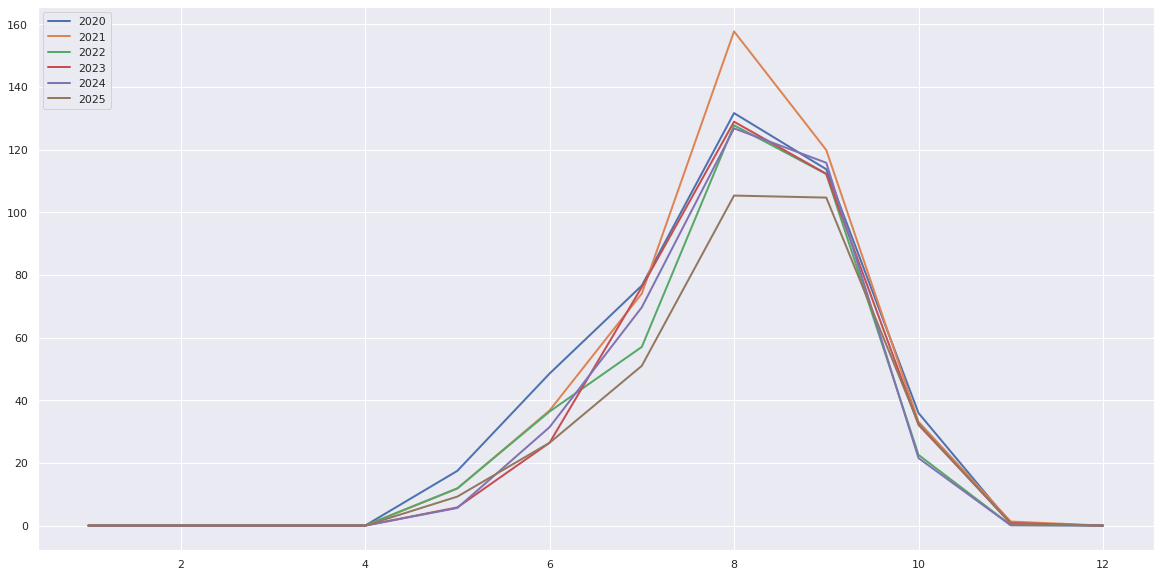

In [ ]:
# plot each year's average monthly max, mean, min precipitation
sns.set()
plt.figure(figsize=(20, 10))
for year in range(len(senegal_pr)):
  plt.plot(np.arange(12)+1, senegal_pr[year], label=date[year][0][:4], linewidth=2)

plt.legend(loc='upper left')

### Expect more precipitation in year 2021 and light precipitation in year 2025 based on precipitation forecast shown above

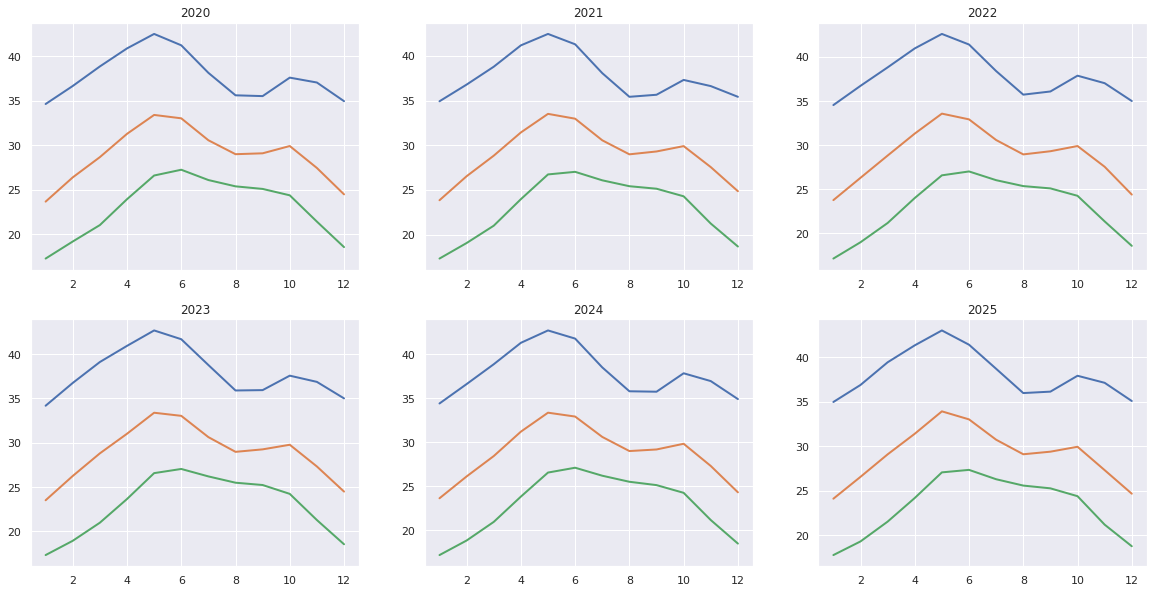

In [ ]:
# plot each year's average monthly max, mean, min temperature
plt.figure(figsize=(20, 10))
for year in range(len(senegal_temp)):
  plt.subplot(2,3,year+1)
  plt.plot(np.arange(12)+1, senegal_temp[year,:,0], label='max', linewidth=2)
  plt.plot(np.arange(12)+1, senegal_temp[year,:,1], label='mean', linewidth=2)
  plt.plot(np.arange(12)+1, senegal_temp[year,:,2], label='min', linewidth=2)
  plt.title(date[year][0][:4])

### Expect slightly hotter weather in year 2025 based on temperature forecast shown above



In [ ]:
# pattern difference: more similar if closer to 1
# amount difference: more similar if closer to 0

# Similarity score of each year's average monthly temperature compare to 2020
pattern_diff = cosine_similarity(senegal_temp[:,:,1])[0]
amount_diff = euclidean_distances(senegal_temp[:,:,1])[0]
print("Average Monthly Temperature Similarity")
for year, pattern, amount in zip(np.arange(start_yr, end_yr+1), pattern_diff, amount_diff):
  print(year, ":", pattern, '\t', amount)

# Similarity score of each year's average monthly precipitation compare to 2020
print()
pattern_diff = cosine_similarity(senegal_pr)[0]
amount_diff = euclidean_distances(senegal_pr)[0]
print("Average Monthly Precipitation Similarity")
for year, pattern, amount in zip(np.arange(start_yr, end_yr+1), pattern_diff, amount_diff):
  print(year, ":", pattern, '\t', amount)

Average Monthly Temperature Similarity
2020 : 1.0 	 0.0
2021 : 0.9999905891625742 	 0.5942221806715791
2022 : 0.999993561734395 	 0.39051248379784803
2023 : 0.9999911813274656 	 0.43266615305813055
2024 : 0.999993265492879 	 0.45694638635021356
2025 : 0.9999786092505366 	 0.9471536306237626

Average Monthly Precipitation Similarity
2020 : 1.0000000000000002 	 0.0
2021 : 0.9930794117431444 	 30.04225191293088
2022 : 0.9929881417204496 	 27.519344105555973
2023 : 0.9924856679163153 	 25.454689155438412
2024 : 0.9921341820589672 	 26.757985723891633
2025 : 0.990859131117339 	 44.68907584634087


### From similarity scores shown above, seems like year 2025 will have slightly more visible weather change